In [61]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
import warnings 
import random
from sklearn.neighbors import KNeighborsClassifier
from libsvm.svmutil import *
warnings.filterwarnings('ignore')
path=os.getcwd()
import cv2

<font size=5> Data Processing

In [121]:
data=pd.DataFrame(np.zeros([4250,1024]))
data_test=pd.DataFrame(np.zeros([1275,1024]))
y=pd.DataFrame(np.zeros([4250,1]))
y1=pd.DataFrame(np.zeros([1275,1]))
count=0
count1=0
folderlist=random.sample(range(1, 68),25) #### random label generation
for j in folderlist:
    totalFiles=0
    for base, dirs, files in os.walk(path+"\\PIE\\"+str(j)+"\\"):
        print('Searching in : ',base)
        for Files in files:
            totalFiles += 1
    for i in range(1,totalFiles+1):
        a=np.array(Image.open(path+"\\PIE\\"+str(j)+"\\"+str(i)+".jpg")).flatten()
        data.loc[count][:]=a.astype('float64')
        y.loc[count][0]=j
        count+=1

Searching in :  D:\Python\PIE\31\
Searching in :  D:\Python\PIE\61\
Searching in :  D:\Python\PIE\45\
Searching in :  D:\Python\PIE\2\
Searching in :  D:\Python\PIE\12\
Searching in :  D:\Python\PIE\49\
Searching in :  D:\Python\PIE\20\
Searching in :  D:\Python\PIE\34\
Searching in :  D:\Python\PIE\15\
Searching in :  D:\Python\PIE\4\
Searching in :  D:\Python\PIE\40\
Searching in :  D:\Python\PIE\64\
Searching in :  D:\Python\PIE\13\
Searching in :  D:\Python\PIE\57\
Searching in :  D:\Python\PIE\54\
Searching in :  D:\Python\PIE\43\
Searching in :  D:\Python\PIE\38\
Searching in :  D:\Python\PIE\6\
Searching in :  D:\Python\PIE\42\
Searching in :  D:\Python\PIE\47\
Searching in :  D:\Python\PIE\46\
Searching in :  D:\Python\PIE\41\
Searching in :  D:\Python\PIE\7\
Searching in :  D:\Python\PIE\22\
Searching in :  D:\Python\PIE\19\


In [122]:
### Train and Test data Separation

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 data, y, test_size=0.3, random_state=42)
x_train=pd.DataFrame(np.zeros([2982,1024]))
Y_train=pd.DataFrame(np.zeros([2982,1]))
x_train.loc[:2974,:]=X_train.values
Y_train.loc[:2974,:]=y_train.values
x_test=pd.DataFrame(np.zeros([1275,1024]))
Y_test=pd.DataFrame(np.zeros([1275,1]))
x_test.loc[:1275,:]=X_test.values
Y_test.loc[:1275,:]=y_test.values

<br> Selfie Image inclusion

In [123]:
### Selfie data inclusion inside the training data set and creation of selfie test data

myimg=[]
for i in range(1,11):
    img=Image.open(path+"\\PIE\\"+str(69)+"\\"+str(i)+".jpg").convert('L')
    myimg.append(img.resize([32,32]))
###selfie training data inclusion
count=2975
for i in range(0,7):
    x_train.loc[count+i,:]=np.array((myimg[i])).flatten()
    Y_train.loc[count+i,:]=68
myImg_test=pd.DataFrame(np.zeros([3,1024]))
yimg_test=pd.DataFrame(np.zeros([3,1]))
for i in range(0,3):
    myImg_test.loc[i,:]=np.array((myimg[i+6])).flatten()
    yimg_test.loc[i,:]=68

<br> Data Saving

In [6]:
### DataSet load
# import scipy.io as sio
# mdir={"x_train":np.array(X_train), "x_test":np.array(X_test), "y_train":np.array(y_train), "y_test":np.array(y_test)}
# sio.savemat('meta.mat', mdir)

<font size=5> PCA

In [104]:
def m_sd(data1): ## function to calculate mean and covariance
    x_mean=pd.DataFrame(np.mean(data1,axis=0)).transpose()
    s=pd.DataFrame(np.zeros([data1.shape[1],data1.shape[1]]))
    cov=((data1.values - x_mean.values).transpose().dot((data1.values - x_mean.values))) / (data1.shape[0]-1)
    return x_mean,cov
def PCA1(x_mean,cov,data1,p): ## function to calculate the eigen vectors and PCA project data
    u,sig,vh=np.linalg.svd(cov)
    X=np.subtract(data1,np.multiply(pd.DataFrame(np.ones([data1.shape[0],data1.shape[1]])).transpose(),(x_mean.transpose())).transpose())
    U=pd.DataFrame(u)
    u_new=U.transpose().loc[:][0:p].transpose()
    l=pd.DataFrame(np.dot(pd.DataFrame(u_new).transpose(),(X).transpose())).transpose()
    return u_new,l
def image_recons(u_new,data1,x_mean,i): #### function to reconstruct the face images
    a=pd.DataFrame(np.dot(u_new,pd.DataFrame(np.dot(u_new.transpose(),(data1.transpose()-np.multiply(pd.DataFrame(np.ones([data1.shape[0],data.shape[1]])).transpose(),(x_mean.transpose())))))))
    b=np.multiply(pd.DataFrame(np.ones([data1.shape[0],data1.shape[1]])).transpose(),(x_mean.transpose()))+a
    pil_image=Image.fromarray(np.reshape(np.array(b.loc[:,i]), (32,32)))
    return pil_image,b.transpose()

PCA testing with KNN classifier

In [132]:
#### PCA testing using the previous functions
m_train,cov_train=m_sd(x_train)
knn=KNeighborsClassifier(n_neighbors=1) ## KNN initialization
dict_pca={}
for j in ([40,80,200]): ### for each dimension the accuracy will be calculated
    a_js,b_js=PCA1(m_train,cov_train,x_train,j)
    img_js,x_til_js=image_recons(a_js,x_train,m_train,2)
    dict_pca["data_pca"+str(j)]=b_js
    #testing the model
    X=(X_test.values-m_train.values)
    trans_test_j=pd.DataFrame(np.dot(pd.DataFrame(a_js).transpose(),(X).transpose())).transpose()
    selfie_data=(myImg_test.values-m_train.values)
    selfie_test_j=pd.DataFrame(np.dot(pd.DataFrame(a_js).transpose(),(selfie_data).transpose())).transpose()
    knn.fit(b_js,Y_train) ## knn fit with the training data
    print("accuracy after considering "+str(j)+" dimensions: ",knn.score(trans_test_j,y_test)*100)
    print("accuracy after considering "+str(j)+" dimensions of selfie data: ",knn.score(selfie_test_j,yimg_test)*100)

accuracy after considering 40 dimensions:  93.64705882352942
accuracy after considering 40 dimensions of selfie data:  100.0
accuracy after considering 80 dimensions:  95.45098039215686
accuracy after considering 80 dimensions of selfie data:  100.0
accuracy after considering 200 dimensions:  96.0
accuracy after considering 200 dimensions of selfie data:  100.0


Plotting 

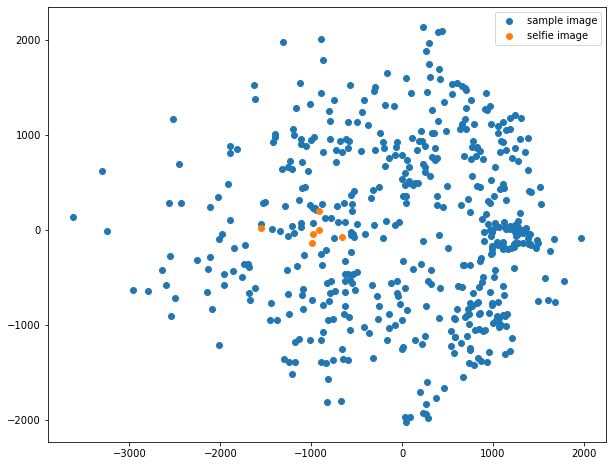

In [135]:
from plotly.subplots import make_subplots
randomlist = random.sample(range(1, 2975), 500) ## 500 random sample generation 
randomlist_selfie=random.sample(range(0,10),7) ## 7 random sample from selfie dataget 
selfie_7=pd.DataFrame(np.zeros([7,1024]))
selfie_y=pd.DataFrame(np.zeros([7,1]))
for i in randomlist_selfie:
    selfie_7.loc[randomlist_selfie.index(i),:]=np.array((myimg[i])).flatten()
    selfie_y.loc[randomlist_selfie.index(i),:]=68
data_500=pd.concat([data.loc[randomlist][:],selfie_7],ignore_index=True) ## concatenation of selfie image with the 500 data sample
y_500=pd.concat([y.loc[randomlist][:],selfie_y],ignore_index=True) ## creation of label for the same
m_vis,cov_vis=m_sd(data_500) ## findind mean and covariance
a_3,b_3=PCA1(m_vis,cov_vis,data_500,3) ## PCA dimension reduction

plt.figure(figsize=(10,8)) 
plt.scatter(b_2.loc[:500,0],b_2.loc[:500,1],label="sample image")
plt.scatter(b_2.loc[501:508,0],b_2.loc[501:508,1],label="selfie image")
plt.legend()
plt.show()

3D plot

In [136]:
fig = px.scatter_3d(b_3, x=0, y=1,z=2,color=y_500.loc[:][0]) ### #D plot using plotly
fig.show()

Visualization of the corresponding 3 eigenfaces

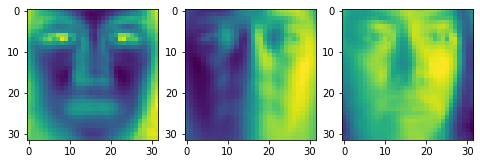

In [137]:
import matplotlib.pyplot as plt
a_3,b_3=PCA1(m_train,cov_train,X_train,3) ## PCA dimension reduction to 3
fig, axes = plt.subplots(1,3, figsize=(8,8)) 
for i,ax in enumerate(axes.flat):
    ax.imshow(np.reshape(np.array(a_3.loc[:,i]),(32,32)))

<font size=5> LDA

In [124]:
Sw=pd.DataFrame(np.zeros([x_train.shape[1],x_train.shape[1]]))
Sb=pd.DataFrame(np.zeros([x_train.shape[1],x_train.shape[1]]))
xbar=pd.DataFrame(np.zeros([25,1024]))
def Sw_Sb(data2,y): ### Function to calculate covarinace within class(Sw) and covariance between classes(Sb)
    Sw=pd.DataFrame(np.zeros([data2.shape[1],data2.shape[1]]))
    Sb=pd.DataFrame(np.zeros([data2.shape[1],data2.shape[1]]))
    xbar=pd.DataFrame(np.zeros([25,1024]))
    m_train=pd.DataFrame(np.mean(data2,axis=0)).transpose()
    count=0
    for i in folderlist:
        d=data2[y.values==float(i)].copy()
        mean=pd.DataFrame(np.mean(d,axis=0)).transpose()
        xbar.loc[count][:]=np.array(mean.transpose()).reshape(1024)
        count+=1
        s=np.subtract(d,np.multiply(pd.DataFrame(np.ones([d.shape[0],d.shape[1]])).transpose(),(mean.transpose())).transpose())
        Sw+=pd.DataFrame(np.dot(s.transpose(),s))
    for i in folderlist:
        d=data2[y.values==float(i)].copy()
        mean=pd.DataFrame(np.mean(d,axis=0)).transpose()
        s=mean-m_train
        Sb+=(d.shape[0])*pd.DataFrame(np.dot(s.transpose(),s))
    return Sw,Sb,xbar
[Sw,Sb,xbar]=Sw_Sb(x_train,Y_train)

In [125]:
eig_vals,eig_vecs=np.linalg.eig(np.matmul(pd.DataFrame(np.linalg.inv(Sw)),Sb))
dict_lda={}
knn=KNeighborsClassifier(n_neighbors=1)
for i in ([2,3,9]): ## for each comnent size the accuracy will be calculated for CMU PIE data and selfie image
    W_i = np.array([eig_vecs[:,0:i]])
    l_i=pd.DataFrame(np.dot(pd.DataFrame(np.array([eig_vecs[:,0:i]]).real.reshape(1024,i)).transpose(),((x_train.transpose().values))))
    l_i=l_i.transpose()
    dict_lda['data_lda'+str(i)]=l_i
    l_test_i=pd.DataFrame(np.dot(pd.DataFrame(np.array([eig_vecs[:,0:i]]).real.reshape(1024,i)).transpose(),((X_test.transpose().values)))).transpose()
    selfie_i=pd.DataFrame(np.dot(pd.DataFrame(np.array([eig_vecs[:,0:i]]).real.reshape(1024,i)).transpose(),((myImg_test.transpose().values)))).transpose()
    knn.fit(l_i,Y_train)
    print("accuracy after considering "+str(i)+" dimensions: ",knn.score(l_test_i,y_test)*100)
    print("accuracy after considering "+str(i)+" dimensions of selfie data: ",knn.score(selfie_i,yimg_test)*100)

accuracy after considering 2 dimensions:  46.74509803921569
accuracy after considering 2 dimensions of selfie data:  33.33333333333333
accuracy after considering 3 dimensions:  61.80392156862745
accuracy after considering 3 dimensions of selfie data:  66.66666666666666
accuracy after considering 9 dimensions:  91.68627450980392
accuracy after considering 9 dimensions of selfie data:  33.33333333333333


Plotting

No handles with labels found to put in legend.


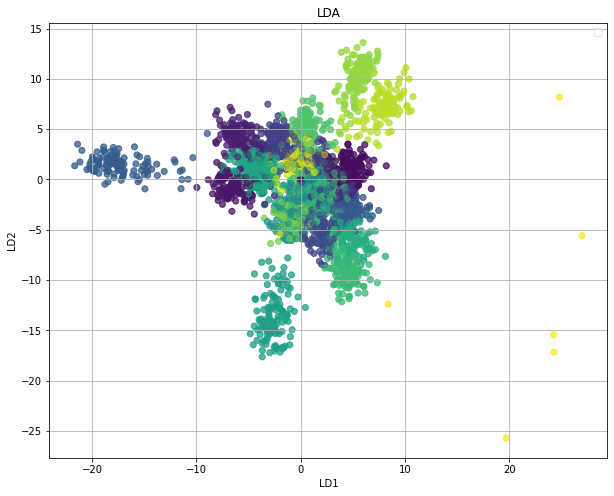

In [138]:
from matplotlib import pyplot as plt
l_2=dict_lda['data_lda2'] 
def plot_step_lda():
    plt.figure(figsize=(10,8))
    for label in range(l_2.shape[1]):
        plt.scatter(x=pd.DataFrame(l_2).loc[:,0],
                y=pd.DataFrame(l_2).loc[:,1],
                alpha=0.5,c=Y_train.loc[:][0])
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA')
    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

In [74]:
l_3=dict_lda['data_lda3']
fig = px.scatter_3d(l_3, x=0, y=1,z=2,color=Y_train.loc[:][0])
fig.show()

<font size=5> SVM

In [133]:
## Dataset for SVM testing
data_svm=x_train
m_train,cov_train=m_sd(data_svm) 

In [140]:
for i in ([0.01,1,0.1]): ## for each value of c that is the penalty 
    for j in ([80,200,1024]): """"for each value of PCA dimension the accuracy of CMU PIE test data and selfie image will be calculated
         using SVM method""""
        a_js,b_js=PCA1(m_train,cov_train,data_svm,j)
        img_js,x_til_js=image_recons(a_js,data_svm,m_train,2)
        prob = svm_problem(np.array(Y_train).reshape(data_svm.shape[0]),np.array(b_js))
        param = svm_parameter('-t 1 -c '+str(i))
        m = svm_train(prob, param)
        #testing the model
        X=(X_test.values-m_train.values)
        trans_test_j=pd.DataFrame(np.dot(pd.DataFrame(a_js).transpose(),(X).transpose())).transpose()
        selfie_data=(myImg_test.values-m_train.values)
        selfie_test_j=pd.DataFrame(np.dot(pd.DataFrame(a_js).transpose(),(selfie_data).transpose())).transpose()
        print("PCA dimension: "+" "+str(j)+" with c "+str(i))
        p_label, p_acc, p_val =svm_predict(np.array(y_test).reshape(1275),np.array(trans_test_j),m)
        p_label, p_acc, p_val =svm_predict(np.array(yimg_test).reshape(3),np.array(selfie_test_j),m)

PCA dimension:  80 with c 0.01
Accuracy = 97.1765% (1239/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  200 with c 0.01
Accuracy = 97.7255% (1246/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  1024 with c 0.01
Accuracy = 97.6471% (1245/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  80 with c 1
Accuracy = 97.1765% (1239/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  200 with c 1
Accuracy = 97.7255% (1246/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  1024 with c 1
Accuracy = 97.6471% (1245/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  80 with c 0.1
Accuracy = 97.1765% (1239/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  200 with c 0.1
Accuracy = 97.7255% (1246/1275) (classification)
Accuracy = 100% (3/3) (classification)
PCA dimension:  1024 with c 0.1
Accuracy = 97.6471% 

<br>
GMM

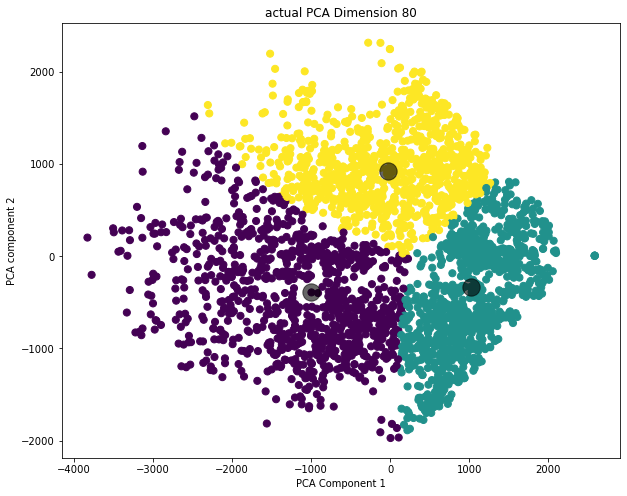

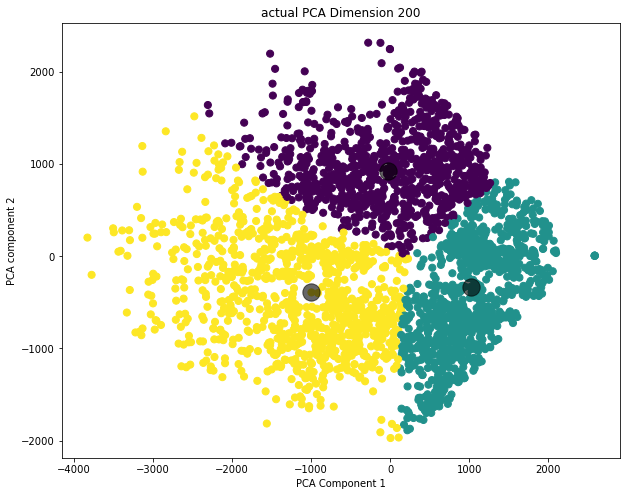

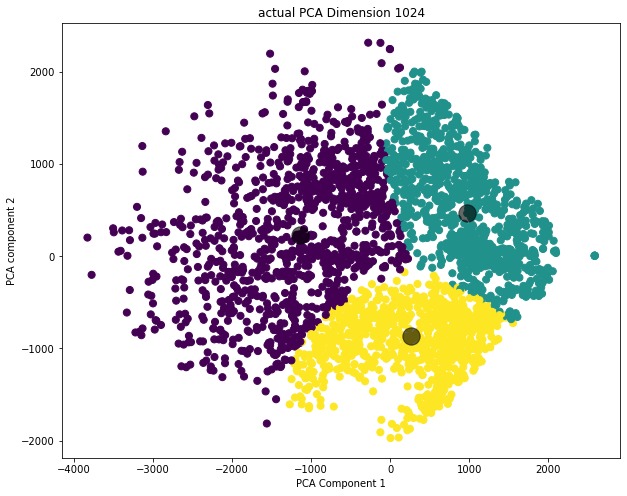

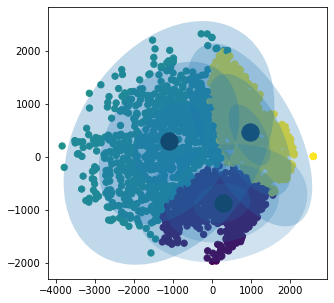

In [150]:
from scipy.stats import multivariate_normal as mvn
from sklearn.mixture import GaussianMixture
# fig, ax = plt.subplots(1,3)
list1=[-dict_pca["data_pca80"], -dict_pca["data_pca200"],x_train]
dimensions=[80,200,1024]
############ PCA dimension reduction and GMM fitting and prediction ####################
for i in range(len(list1)):
    m_train,cov_train=m_sd(list1[i])
    _,data_new = PCA1(m_train,cov_train,list1[i],2)
    data_new=np.array(data_new)
    gmm = GaussianMixture(n_components=3, init_params='kmeans').fit(data_new)
    prediction_gmm = gmm.predict(data_new)
    probs = gmm.predict_proba(data_new)
    ########################################################################################

    ############################## initialization of the density and centers ###############
    centers = np.zeros((3,2))
    for j in range(3):
        density = mvn(cov=gmm.covariances_[j], mean=gmm.means_[j]).logpdf(data_new)
        centers[j, :] = data_new[np.argmax(density)]
    #########################################################################################

    plt.figure(figsize = (10,8))
    plt.title("actual PCA Dimension "+ str(dimensions[i]))
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA component 2")
    plt.scatter(data_new[:, 0], data_new[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

################################ Ellipse Function Building ##############################
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
###########################################################################################


_,Y_sklearn = PCA1(m_train,cov_train,x_train,2)
data_new=np.array(data_new)
gmm = GaussianMixture(n_components=3, init_params='kmeans').fit(data_new)
prediction_gmm = gmm.predict(data_new)
probs = gmm.predict_proba(data_new)
########################################################################################

############################## initialization of the density and centers ###############
centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(data_new)
    centers[i, :] = data_new[np.argmax(density)]

##########################  Plotting #######################################################
plt.figure(figsize = (5,5))
plt.scatter(data_new[:, 0], data_new[:, 1],c=prediction_gmm ,s=40, cmap='viridis', zorder=1)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=1.0);

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w*.75)


<br>CNN

In [45]:
""" Data Manupulation"""
x_train1=np.array(x_train).reshape(2982,32,32,1)
x_test1=np.array(x_test).reshape(1275,32,32,1)
selfiex_test=np.array(myImg_test).reshape(3,32,32,1)

from sklearn import preprocessing
lb=preprocessing.MultiLabelBinarizer()
labels=lb.fit_transform(Y_train.values)
label_dict={}
label_cnn=[]
for (i, label) in enumerate(lb.classes_):
    label_dict[str(i)]=label
    label_cnn.append(i)
def transform1(Y,dict):
    Y1=Y.copy()
    for i in range(Y.shape[0]):
        key=[key for key,value in dict.items() if value == Y.loc[i][0]]
        Y1.loc[i][0]=int(key[0])
    return Y1
Y_train1=transform1(Y_train,label_dict)
Y_test1=transform1(Y_test,label_dict)
yimg_test1=transform1(yimg_test,label_dict)

################################################################################

""" Keras Model Initialization """
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(20,strides=(1,1),kernel_size=(5,5),input_shape=(32,32,1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Conv2D(50,strides=(1,1),kernel_size=(5,5)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500,activation='relu'))
model.add(tf.keras.layers.Dense(26,activation='softmax'))
model.compile(optimizer='ADAM', loss='sparse_categorical_crossentropy', metrics=['acc'])

#################################################################################
""" fitting the model with training data"""
model.fit(x_train1, np.array(Y_train1), epochs=5)

####################################################################################
""" testing on the CMU PIE test data and selfie image """
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test1, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, Y_test1)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(selfiex_test, training=False)
prediction = tf.argmax(logits, axis=1)
test_accuracy(prediction, tf.convert_to_tensor(yimg_test1))
print("Selfie image accuracy: {:.3%}".format(test_accuracy.result()))


AttributeError: module 'tensorflow.python.util.dispatch' has no attribute 'add_fallback_dispatch_list'